In [ ]:
import numpy as np
import pandas as pd

import os, glob, shutil, copy

#------------------------------------

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW

#------------------------------------

import poseigen_seaside.basics as se
import poseigen_seaside.metrics as mex
import poseigen_seaside.visuals as viz

import poseigen_compass as co
import poseigen_binmeths as bm

import poseigen_trident.utils as tu

import poseigen_oyster as oys
import poseigen_oyster.analysis as interp

#------------------------------------

import R3_xps_functions as xpfus

In [ ]:
# get to the data/R3 folder

# data_path = "../data/R3/"
# os.makedirs(data_path, exist_ok=True)

# os.chdir(data_path)

In [3]:
fin_bins = se.PickleLoad('fin_bins')
print(fin_bins)

divset = ['Train', 'Stop.', ' Eval', 'Test']

xpsfolder = se.NewFolder('xps_4')

10


In [4]:
RO_folder = se.NewFolder('RO')

ex_oys_folder = se.NewFolder(RO_folder + 'exact')
oys_iter = 11
pn_RO_exact = se.NewFolder(ex_oys_folder + 'RO_' + str(oys_iter))
pn_RO_exact_top = se.NewFolder(pn_RO_exact + 'Top' + str(0))
exact_ranked_can_dict = se.PickleLoad(pn_RO_exact + 'ranked_can_dict')

exact_dict = exact_ranked_can_dict[0]

In [5]:
yy1_split_transaug = se.PickleLoad('yy1_split_transaug')

yy1_max = se.PickleLoad('yy1_max')

tri_tpacks = se.PickleLoad('tri_tpacks')

d_x1, d_y_ms, d_s, d_b, d_x2 = tri_tpacks

d_s_rs = np.swapaxes(np.expand_dims(d_s, axis = -1), 1, -1)

In [6]:
histones = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K9ac', 
            'H3K4me2', 'H4K20me1', 'H2AFZ', 'H3K79me2']

In [7]:
xp6_trial = 3                                           #@@@@@@@@@@@@@@@@@@
xp6_id = 'xp6' + '_' + str(xp6_trial) 
pn_xp6 = se.NewFolder(xpsfolder + xp6_id)
pn_xpF, icof, best_icom = pn_xp6, 0, 7                       #@@@@@@@@@@@@@@@@@@

pn_t1 = se.NewFolder(pn_xpF + str(icof))
pn_t2 = se.NewFolder(pn_t1 + str(best_icom))

ex_ens_idx = se.PickleLoad(pn_t2 + 'ensemble_idx')

ex_ens_pn_preds, ex_ens_pn_mods = [[pn_t2 + '0_' + str(ir) + s 
                                    for ir in ex_ens_idx]
                                   for s in ['_preds.p',  '_Mod.pt']]

# Sequence Contributions

In [ ]:
not_test = np.delete(np.arange(len(d_x1)), yy1_split_transaug[-1])

d_b_nt = d_b[not_test].reshape(-1)

#-------------------------------------

# nuc_contrib = np.mean(np.array([tu.FeatExtract(mo, 'OysterA', [d_x1, d_x2], batchsize = 512) 
#                                 for mo in ex_ens_pn_mods]), 
#                                 axis = 0)

# se.PickleDump(nuc_contrib, pn_xpF + 'nuc_contrib')

# #-------------------------------------

# sigs_contrib = interp.SigContrib(ex_ens_pn_mods, d_x2, sub_model = 'OysterB')

# se.PickleDump(sigs_contrib, pn_xpF + 'sigs_contrib')

In [10]:
nuc_contrib = se.PickleLoad(pn_xpF + 'nuc_contrib')
nuc_contrib_abs = np.abs(nuc_contrib)
nuc_contrib_nt = nuc_contrib_abs[not_test]

sigs_contrib = se.PickleLoad(pn_xpF + 'sigs_contrib')
sigs_contrib_abs = np.abs(sigs_contrib)
sigs_contrib_nt = sigs_contrib_abs[not_test]

#--------------------------------------------------

comb_contrib_abs = np.concatenate([nuc_contrib_nt.reshape(-1, 1), 
                               sigs_contrib_nt], axis = 1)

comb_contrib_abs_sumd = np.sum(comb_contrib_abs, axis = 1, keepdims=True)

comb_influ = comb_contrib_abs / comb_contrib_abs_sumd

comb_influ_bind = [comb_influ[d_b_nt == b] for b in np.arange(fin_bins)]
comb_influ_bind_mean = np.array([np.mean(x, axis = 0) for x in comb_influ_bind]).T

comb_influ_bind_mean.shape

#-------------------------------------------------

pdx = pd.DataFrame(comb_influ_bind_mean)
pdx.index = ['DNA'] + histones
pdx.columns = np.arange(fin_bins) + 1

pdx['Mean'] = np.mean(comb_influ_bind_mean, axis = -1)
#pdx['Max'] = np.max(comb_influ_bind_mean, axis = -1)

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Greys', axis = None, 
                                                            vmin = 0, vmax = 1)
pdx_sty

,1,2,3,4,5,6,7,8,9,10,Mean
DNA,0.464,0.560,0.558,0.570,0.593,0.602,0.636,0.658,0.713,0.770,0.612
H3K4me3,0.005,0.027,0.036,0.037,0.039,0.038,0.036,0.031,0.029,0.021,0.030
H3K27ac,0.029,0.077,0.070,0.064,0.059,0.053,0.046,0.042,0.035,0.027,0.050
H3K27me3,0.118,0.060,0.046,0.038,0.034,0.028,0.024,0.021,0.017,0.014,0.040
H3K4me1,0.078,0.048,0.053,0.053,0.048,0.056,0.043,0.042,0.037,0.030,0.049
H3K36me3,0.015,0.010,0.008,0.007,0.006,0.006,0.005,0.005,0.004,0.003,0.007
H3K9me3,0.044,0.026,0.022,0.020,0.018,0.016,0.013,0.012,0.011,0.009,0.019
H3K9ac,0.021,0.100,0.132,0.140,0.137,0.143,0.141,0.141,0.111,0.093,0.116
H3K4me2,0.000,0.000,0.001,0.001,0.001,0.001,0.001,0.000,0.001,0.001,0.001
H4K20me1,0.002,0.001,0.001,0.001,0.001,0.000,0.001,0.001,0.001,0.000,0.001


In [11]:
refi_combs = [pdx.index[pdx['Mean'] > thre].to_list() for thre in [0, 0.025, 0.05, 0.1, 0.2]]

refi_combs

[['DNA',
  'H3K4me3',
  'H3K27ac',
  'H3K27me3',
  'H3K4me1',
  'H3K36me3',
  'H3K9me3',
  'H3K9ac',
  'H3K4me2',
  'H4K20me1',
  'H2AFZ',
  'H3K79me2'],
 ['DNA', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K9ac', 'H2AFZ'],
 ['DNA', 'H3K27ac', 'H3K9ac', 'H2AFZ'],
 ['DNA', 'H3K9ac'],
 ['DNA']]

# xpHIS

In [12]:
masterpseudo = 1e-10

RMS_mode = [mex.MeanExpo, {'expo': 2, 'root': True}]
RMS_mode_pyt = [mex.MeanExpo, {'expo': 2, 'root': True, 'pyt': True}]

bm_args_np = {'byaxis': 1, 'useweights': False, 'seperate': False, 
              'summarize_mode': RMS_mode}

bm_args_pyt = {'byaxis': 1, 'useweights': False, 'seperate': False, 
               'summarize_mode': RMS_mode_pyt, 'pyt': True}

#------------------------------------------------

deverr_args_base = {'expo': 1, 'root': False,                                                       #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
                    'pseudo': masterpseudo,
                    'scalefactor': yy1_max}

MDE_mode_np = [mex.DeviaError, {**deverr_args_base, 'pyt': False}]
MDE_mode_pyt = [mex.DeviaError, {**deverr_args_base, 'pyt': True}]  

B_MDE_mode_np = [tu.BinnedLoss, {'metrics_mode': MDE_mode_np, **bm_args_np}]
B_MDE_mode_pyt = [tu.BinnedLoss, {'metrics_mode': MDE_mode_pyt, **bm_args_pyt}]

In [ ]:
flipo = [[-2, -1], [-2, -1]]

TCR_repeats = 15

modo = oys.DualOyster
duds_mode = [xpfus.Reset_DualOyster, {}]

TT_base =  {
    'inps': [d_x1, d_x2], 'out': d_y_ms, 
    'out_std': d_s_rs, 'out_bind': d_b,
    'Split': yy1_split_transaug,   
    'EUS': None, 'obs_weight': None,                    #!@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

    'mod_init_mode': duds_mode, 'duds': TCR_repeats,

    
    'metrics_mode': B_MDE_mode_np, 'smallest': True,
    'opt': Adam, 'maxepochs': 100, 
    'patience': 8, 'pickup': True,
    'flips': flipo, 'indivflips': True}

TCS_base = {'trainer': tu.TridentTrainer, 
                 'smallest': None,
                 'get_predictions': True, 'pred_rewrite': False, 
                 'add_pred_args': {'batchsize': 512, 'flips': flipo, 'avg_flips': True},
                 'score_on': 1, 'score_only': False} ### SCORING ON THE EVAL SET, MAKING ONMLY PREDS FOR IT. 


TCR_base = {'Splits': None, 'repeats': TCR_repeats,
               'pickup': False, 'savemodels': True, 'returnmodel': True}

#--------------------------------------------------------------------------

es_args = {'out': d_y_ms, 'out_std': d_s_rs, 'out_bind': d_b,
            'split': yy1_split_transaug,
            'metrics_mode': B_MDE_mode_np, 
            'score_on': 1,
            'std_cutoff': None, 'ddof': 1, 'top': 3, 'smallest': True}

In [13]:
xpHIS_trial = 8                                    #5 was comb 3, 7 was comb 4, 8 is comb 7, 9 is comb 4 (again)
xpHIS_id = 'xpHIS' + '_' + str(xpHIS_trial) 
pn_xpHIS = se.NewFolder(xpsfolder + xpHIS_id)

xpHIS_variables = ['HisCombs']

hiscombs = refi_combs
hiscombs_nodna = [[h for h in hx if h != 'DNA'] for hx in hiscombs]
hiscombs_nodna_idx = [[histones.index(h) for h in hx] for hx in hiscombs_nodna]

xpHIS_combs = [[ic, [c]] for ic,c in enumerate(hiscombs_nodna_idx)]
xpHIS_combs

[[0, [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]],
 [1, [[0, 1, 2, 3, 6, 9]]],
 [2, [[1, 6, 9]]],
 [3, [[6]]],
 [4, [[]]]]

In [ ]:
if best_icom == 3: 
    lmo, lbx = MDE_mode_pyt, False
    sampweimode = [bm.BinWeighter, {'uni': np.arange(fin_bins), 'byaxis': None, 
                                     'minus': False, 'newrange': True}]
    usxo = 0.2
    wei_bin = True
    
elif best_icom == 4: 
    lmo, lbx = B_MDE_mode_pyt, True
    sampweimode = None
    usxo = None
    wei_bin = False

elif best_icom == 7: 
    lmo, lbx = B_MDE_mode_pyt, True
    sampweimode = [bm.BinWeighter, {'uni': np.arange(fin_bins), 'byaxis': None, 
                                     'minus': False, 'newrange': True}]
    usxo = 0.2
    wei_bin = True
    

xpHIS_TT_args = {
                'loss_mode': lmo, 'loss_bind': lbx,
                'weights_mode': sampweimode, 'weights_bind': wei_bin,          
                **TT_base}

xpHIS_TT_args.update({'EUS': usxo, 'obs_weight': d_b.reshape(-1)})

xpHIS_TCS_args = {'trainer_args': xpHIS_TT_args, **TCS_base}


xpHIS_rewrite = True

for icof in np.arange(1):                                   # PLACEHOLDER

    for icom, com in xpHIS_combs:

        pn_t1 = se.NewFolder(pn_xpHIS + str(icof))
        pn_t2 = se.NewFolder(pn_t1 + str(icom))

        par_xp, par_unit = None, None
        if icom == 0: par_xp, par_unit = xp6_id, best_icom                                  #!!!!!!!!!!!!!!!!!!!!!!

        print(par_xp, par_unit)

        if par_unit is not None: 
            xpfus.XpsCopy(cur_pn = pn_t2, cur_xp_id = xpHIS_id, 
                    past_xp_id = par_xp, past_unit = par_unit, 
                    rewrite = xpHIS_rewrite)
        
        xpHIS_TCR_args = {**xpHIS_TCS_args, **TCR_base, 'pathname': pn_t2}

        #-------------------------------------------

        qox = com[0]

        print(qox)
        
        cof = copy.deepcopy(exact_dict)
        cof.update({'B_incl_only': qox})

        _, _= tu.TridentCanRepeater(modo, cof, data = None, **xpHIS_TCR_args)

In [ ]:
xpHIS_bs_all, xpHIS_bs_r2r_all = xpfus.XpsResults(pn_xpHIS, xpHIS_combs, ref_ic = 0, rewrite = False)

xpHIS_tab_main, xpHIS_tab_main_sty, xpHIS_tab_extra, xpHIS_tab_extra_sty = xpfus.XpsTables(pn_xpHIS, xpHIS_combs, 
                                                                                   xpHIS_variables, 

                                                                                   ref_ic = [0, 4])

xpHIS_tab_main_sty 

---- Finished 0 ----
---- Finished 1 ----
---- Finished 2 ----
---- Finished 3 ----
---- Finished 4 ----
**** Finished 0 ****
per shape for ref_ic=0: (5, 1), columns=MultiIndex([(0, 0)],
           names=['ref_ic', 'config'])
per shape for ref_ic=4: (5, 1), columns=MultiIndex([(4, 0)],
           names=['ref_ic', 'config'])


ref_ic,0,4
config,0,0
HisCombs,,
"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)",0.2,-12.5
"(0, 1, 2, 3, 6, 9)",2.9,-10.1
"(1, 6, 9)",7.4,-6.2
"(6,)",4.1,-9.1
(),14.6,0.1


In [41]:
xpHIS_tab_extra_sty

## Final Performance

In [42]:
best_hiscombs_icom = 1

hiscombs_nodna_idx[best_hiscombs_icom]

[0, 1, 2, 3, 6, 9]

In [ ]:
cof = copy.deepcopy(exact_dict)
cof.update({'B_incl_only': hiscombs_nodna_idx[best_hiscombs_icom]})

oys.DualOyster(**{k:v for k,v in cof.items() if k not in ['batchsize', 'learningrate']})

(6, 40, 1)


DualOyster(
  (OysterA): Oyster(
    (Reflect): Identity()
    (kE): Sequential(
      (0): Conv2d(1, 31, kernel_size=(7, 4), stride=(1, 1), padding=valid)
      (1): BatchNorm2d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(31, 65, kernel_size=(7, 1), stride=(1, 1), padding=valid)
      (4): BatchNorm2d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(65, 105, kernel_size=(3, 1), stride=(1, 1), padding=valid)
      (7): BatchNorm2d(105, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(105, 150, kernel_size=(1, 1), stride=(1, 1), padding=valid)
      (10): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
    )
    (AntiReflect): Identity()
    (P): AvgPool2d(kernel_size=(50, 1), stride=(50, 1), padding=(7, 0))
    (O): Sequential(
      (0): Dropout2d(p=0.2, inplace=False)
 

In [44]:
pn_xpF, icof, icom = pn_xpHIS, 0, best_hiscombs_icom

pn_t1 = se.NewFolder(pn_xpF + str(icof))
pn_t2 = se.NewFolder(pn_t1 + str(icom))

ex_pn_preds = [pn_t2 + '0_' + str(ir) + '_Preds.p' 
                  for ir in range(TCR_repeats)]

#-----------------------------------------------------

_ = co.EnsembleScorer(ex_pn_preds, **es_args,
                   pathname = pn_t2, return_extra = False)

ex_ens_idx = se.PickleLoad(pn_t2 + 'ensemble_idx')
print(ex_ens_idx)

ex_ens_pn_preds, ex_ens_pn_mods = [[pn_t2 + '0_' + str(ir) + s 
                                    for ir in ex_ens_idx]
                                   for s in ['_preds.p',  '_Mod.pt']]

ex_ens_preds = np.stack([se.PickleLoad(p) for p in ex_ens_pn_preds]).mean(0)

[3 7 2]


0.2748


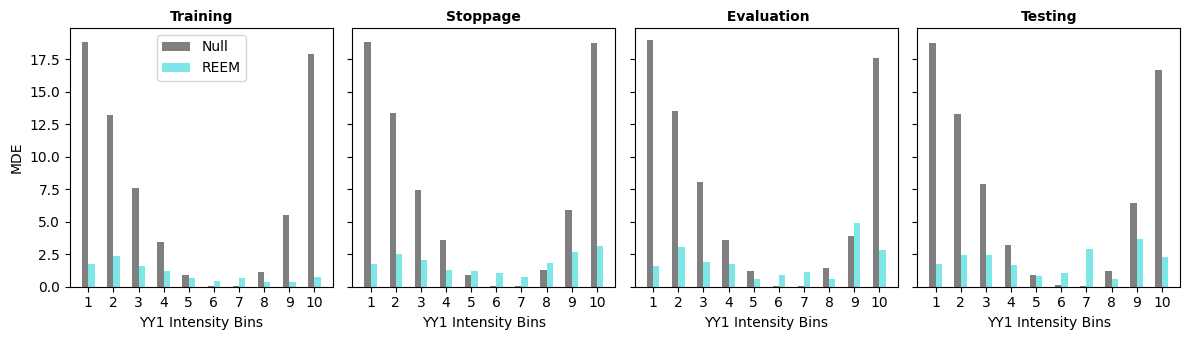

In [ ]:
BM_args = {'metrics_mode': MDE_mode_np, 'summarize_mode': None}

ex_ens_BM = np.array([tu.BinnedLoss(ex_ens_preds[O], d_y_ms[O],
                        std = d_s_rs[O], bind = d_b[O].reshape(-1),
                        **BM_args) for O in yy1_split_transaug])

#----------------------------------------------------

nullo = se.PickleLoad('nullo')

print(nullo)

nullo_BM = np.array([tu.BinnedLoss(np.full(d_y_ms[O].shape, nullo), 
                                   d_y_ms[O],
                        std = d_s_rs[O], bind = d_b[O].reshape(-1),
                        **BM_args) for O in yy1_split_transaug])

#-----------------------------------------------------

comb_BM = np.concatenate([nullo_BM, ex_ens_BM], axis = 1) 

comb_BM_red = [[np.arange(fin_bins) + 1, comb_BM[io]] for io in np.arange(len(yy1_split_transaug))]

#-----------------------------------------------------



divset = ['Training', 'Stoppage', ' Evaluation', 'Testing']

mp_args = {'multi': True, 'paired': False, 'transpose': True, 
           'columntitle': divset,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (12, 3.5), 'fontsize': 10,
           'sharey': True, 'sharex': True}

bp_args = {'xlabel': 'YY1 Intensity Bins',
            'labelheight': False, 'alpha': 0.5, 
            'group': ['Null', 'REEM'], 'color': ['black', 'darkturquoise'], 
            'width': 0.25}

mp_args = {'multi': True, 'paired': False, 'transpose': True, 
           'columntitle': divset,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (12, 3.5), 'fontsize': 10,
           'sharey': True, 'sharex': True}

viz.MultiPlot(comb_BM_red, **mp_args,  
          plt_mode = [viz.BarPlot, bp_args], 
          indiv_args = {'legend': [True, False, False, False], 
                        'ylabel': ['MDE', None, None, None]});

In [ ]:
not_test = np.delete(np.arange(len(d_x1)), yy1_split_transaug[-1])

d_b_nt = d_b[not_test].reshape(-1)

# #-------------------------------------

nuc_contrib = np.mean(np.array([tu.FeatExtract(mo, 'OysterA', [d_x1, d_x2], batchsize = 512) 
                                for mo in ex_ens_pn_mods]), 
                                axis = 0)

se.PickleDump(nuc_contrib, pn_xpF + 'nuc_contrib')

#-------------------------------------

sigs_contrib = interp.SigContrib(ex_ens_pn_mods, d_x2[:, hiscombs_nodna_idx[best_hiscombs_icom]],
                              sub_model = 'OysterB')

se.PickleDump(sigs_contrib, pn_xpF + 'sigs_contrib')

In [82]:
nuc_contrib = se.PickleLoad(pn_xpF + 'nuc_contrib')
nuc_contrib_abs = np.abs(nuc_contrib)
nuc_contrib_nt = nuc_contrib_abs[not_test]

nuc_contrib_bind = [nuc_contrib_nt[d_b_nt == b] for b in np.arange(fin_bins)]
nuc_contrib_means = np.array([np.mean(x) for x in nuc_contrib_bind]).reshape(1, -1)
nuc_contrib_std = np.array([np.std(x) for x in nuc_contrib_bind]).reshape(1, -1)

In [83]:
sigs_contrib = se.PickleLoad(pn_xpF + 'sigs_contrib')
sigs_contrib_abs = np.abs(sigs_contrib)
sigs_contrib_nt = sigs_contrib_abs[not_test]

sigs_contrib_bind = [sigs_contrib_nt[d_b_nt == b] for b in np.arange(fin_bins)]
sigs_contrib_means = np.array([np.mean(x, axis = 0) for x in sigs_contrib_bind]).T
sigs_contrib_stds = np.array([np.std(x, axis = 0) for x in sigs_contrib_bind]).T

In [84]:
all_contrib_means = np.vstack([nuc_contrib_means, sigs_contrib_means ])
all_contrib_maxs = all_contrib_means.max(1)

comb_contrib_nt = np.hstack([nuc_contrib_nt.reshape(-1, 1), sigs_contrib_nt])


In [86]:
comb_bind = [comb_contrib_nt[d_b_nt == b] for b in np.arange(fin_bins)]
comb_means = np.array([np.mean(x, axis = 0) for x in comb_bind]).T

# influ_thresh = 0.2

# def boldo(x): 
#         return ['font-weight: bold' if y >= influ_thresh else '' for y in x]

pdx = pd.DataFrame(comb_means)
pdx.index = ['DNA'] + [h for ih, h in enumerate(histones) if ih in hiscombs_nodna_idx[best_hiscombs_icom]]
pdx.columns = np.arange(fin_bins) + 1

pdx['Mean'] = np.mean(comb_means, axis = -1)

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Greys', axis = None, 
                                                            vmin = 0, vmax = 1)
pdx_sty

,1,2,3,4,5,6,7,8,9,10,Mean
DNA,0.056,0.101,0.120,0.145,0.164,0.190,0.239,0.275,0.342,0.447,0.208
H3K4me3,0.019,0.009,0.008,0.009,0.009,0.008,0.009,0.009,0.009,0.009,0.010
H3K27ac,0.001,0.007,0.009,0.010,0.011,0.014,0.016,0.016,0.015,0.017,0.012
H3K27me3,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
H3K4me1,0.009,0.010,0.014,0.017,0.017,0.022,0.021,0.023,0.024,0.025,0.018
H3K9ac,0.001,0.009,0.014,0.017,0.017,0.021,0.024,0.026,0.025,0.025,0.018
H2AFZ,0.013,0.011,0.012,0.013,0.014,0.015,0.017,0.015,0.016,0.019,0.014


In [88]:
comb_contrib_tot = comb_contrib_nt.sum(-1).reshape(-1, 1)
comb_contrib_scaled = comb_contrib_nt / comb_contrib_tot

comb_bind = [comb_contrib_scaled[d_b_nt == b] for b in np.arange(fin_bins)]
comb_means = np.array([np.mean(x, axis = 0) for x in comb_bind]).T

# influ_thresh = 0.2

# def boldo(x): 
#         return ['font-weight: bold' if y >= influ_thresh else '' for y in x]

pdx = pd.DataFrame(comb_means)
pdx.index = ['DNA'] + [h for ih, h in enumerate(histones) if ih in hiscombs_nodna_idx[best_hiscombs_icom]]
pdx.columns = np.arange(fin_bins) + 1

pdx['Mean'] = np.mean(comb_means, axis = -1)

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Greys', axis = None, 
                                                            vmin = 0, vmax = 1)
pdx_sty

,1,2,3,4,5,6,7,8,9,10,Mean
DNA,0.539,0.677,0.671,0.674,0.697,0.691,0.720,0.743,0.780,0.819,0.701
H3K4me3,0.203,0.067,0.050,0.045,0.039,0.033,0.028,0.026,0.021,0.016,0.053
H3K27ac,0.012,0.051,0.053,0.051,0.049,0.053,0.053,0.046,0.039,0.033,0.044
H3K27me3,0.008,0.002,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001
H3K4me1,0.089,0.065,0.077,0.081,0.075,0.086,0.067,0.067,0.058,0.047,0.071
H3K9ac,0.012,0.060,0.079,0.082,0.078,0.080,0.076,0.075,0.061,0.049,0.065
H2AFZ,0.137,0.078,0.069,0.066,0.062,0.058,0.055,0.043,0.041,0.036,0.065


# Histone Correlation

In [8]:
hisos = np.swapaxes(d_x2, 0, 1).reshape(len(histones), -1)

his_corrs = []
for ih1, h1 in enumerate(histones): 
    for ih2, h2 in enumerate(histones): 
        
        if h1 != h2: 
            cor = se.Correlation(hisos[ih1], hisos[ih2]) ** 2
            if cor > 0.7 or cor < -0.7 : print(f'{h1, h2, cor}')

('H3K4me3', 'H3K9ac', np.float64(0.8034583769156313))
('H3K4me3', 'H3K4me2', np.float64(0.8536944659484123))
('H3K27ac', 'H3K9ac', np.float64(0.7214973909036583))
('H3K9ac', 'H3K4me3', np.float64(0.8034583769156313))
('H3K9ac', 'H3K27ac', np.float64(0.7214973909036585))
('H3K9ac', 'H3K4me2', np.float64(0.7007811703625937))
('H3K4me2', 'H3K4me3', np.float64(0.8536944659484123))
('H3K4me2', 'H3K9ac', np.float64(0.7007811703625937))


In [12]:
not_test = np.delete(np.arange(len(d_x1)), yy1_split_transaug[-1])

d_x2_nt = d_x2[not_test]

hisos_nt = np.swapaxes(d_x2_nt, 0, 1).reshape(len(histones), -1)

his_corrs = se.PairwiseFuncer(hisos_nt, hisos_nt, mode1 = [se.Correlation, {}])

his_corrs = np.array(his_corrs).reshape(len(histones), -1)

his_r2 = his_corrs ** 2

In [13]:
pdx = pd.DataFrame(his_corrs, columns=histones, index=histones)

def boldo(x):
    return['font-weight: bold' if u > 0.7 else '' for u in x]

pdx_sty = pdx.style.format(precision=2).apply(boldo, axis = 1).background_gradient(axis = None, 
                                                                                   vmin = 0, vmax = 1,
                                                                                     cmap = 'Greys')

pdx_sty

,H3K4me3,H3K27ac,H3K27me3,H3K4me1,H3K36me3,H3K9me3,H3K9ac,H3K4me2,H4K20me1,H2AFZ,H3K79me2
H3K4me3,1.00,0.71,-0.08,0.07,0.04,0.00,0.90,0.93,0.16,0.54,0.58
H3K27ac,0.71,1.00,-0.08,0.29,0.05,0.02,0.85,0.75,0.05,0.52,0.33
H3K27me3,-0.08,-0.08,1.00,-0.11,-0.09,0.10,-0.08,-0.07,0.18,-0.08,-0.09
H3K4me1,0.07,0.29,-0.11,1.00,0.15,0.07,0.10,0.20,0.14,0.32,0.10
H3K36me3,0.04,0.05,-0.09,0.15,1.00,0.17,0.04,0.06,0.36,-0.14,0.33
H3K9me3,0.00,0.02,0.10,0.07,0.17,1.00,-0.01,0.01,0.04,0.04,0.03
H3K9ac,0.90,0.85,-0.08,0.10,0.04,-0.01,1.00,0.84,0.10,0.51,0.53
H3K4me2,0.93,0.75,-0.07,0.20,0.06,0.01,0.84,1.00,0.17,0.59,0.52
H4K20me1,0.16,0.05,0.18,0.14,0.36,0.04,0.10,0.17,1.00,-0.12,0.43
H2AFZ,0.54,0.52,-0.08,0.32,-0.14,0.04,0.51,0.59,-0.12,1.00,0.00


In [21]:
import os

# Set up the output folder
os.makedirs("tables", exist_ok=True)
output_path = "tables/his_correlations.xlsx"

# Round the DataFrame to 2 decimal places BEFORE styling
pdx_2dec = pdx.round(2)

# Define border style for all cells
border_style = {
    "selector": "td, th",
    "props": [
        ("border", "1px solid black"),
        ("font-family", "'Times New Roman', Times, serif"),
        ("font-size", "11pt"),
        ("text-align", "center"),
        ("vertical-align", "middle"),
    ]
}

# Apply styles to the Styler
pdx_sty = (
    pdx_2dec.style
    .format("{:.2f}")  # For display and Excel
    .apply(boldo, axis=1)
    .background_gradient(axis=None, vmin=0, vmax=1, cmap="Greys")
    .set_table_styles([border_style], overwrite=False)
    .set_properties(**{
        "font-family": "'Times New Roman', Times, serif",
        "font-size": "11pt",
        "text-align": "center",
        "vertical-align": "middle",
        "border": "1px solid black"
    })
)

# Save to Excel with styles preserved
pdx_sty.to_excel(output_path, engine="openpyxl", index=True)

# Adjust column widths to 30 points using openpyxl
from openpyxl import load_workbook

wb = load_workbook(output_path)
ws = wb.active

for col in ws.columns:
    col_letter = col[0].column_letter
    ws.column_dimensions[col_letter].width = 15  # 30 points

wb.save(output_path)

print(f"Saved styled correlation table to {output_path} with 2 decimal places and column width 15.")

Saved styled correlation table to tables/his_correlations.xlsx with 2 decimal places and column width 15.
